# Прогрессивный анализ влияния признаков на качество прогнозирования

Этот ноутбук предназначен для анализа того, как поэтапное добавление различных типов признаков влияет на качество прогнозирования временных рядов.

## Этапы анализа:
1. **Базовая модель** - обучение только на ряду `close` (univariate)
2. **+ Аномалии** - добавление колонки аномалий
3. **+ Новости** - добавление взвешенной оценки новостей  
4. **+ Паттерны свечей** - добавление паттернов японских свечей
5. **+ Технические индикаторы** - добавление технических индикаторов
6. **+ TSFresh признаки** - добавление статистических свойств временных рядов
7. **+ PCA компоненты** - добавление сжатых признаков

## Метрики оценки:
- **RMSE** - среднеквадратичная ошибка
- **MAPE** - средняя абсолютная процентная ошибка  
- **DA** - точность направления (Directional Accuracy)

## Модель:
- **RandomForest** из DARTS с анализом важности признаков
- **Горизонт прогноза**: последние 20 дней


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# DARTS библиотеки
from darts import TimeSeries
from darts.models import RandomForest
from darts.metrics import rmse, mape
from darts.utils.utils import SeasonalityMode, TrendMode

# Библиотеки для анализа
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import os
from pathlib import Path

# Настройка отображения
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Библиотеки загружены успешно")

Библиотеки загружены успешно


In [3]:
# Пути к данным
INPUT_PATH = '../../data/multivariate_series/'
OUTPUT_PATH = './progressive_analysis/'

# Создаем выходную папку если её нет
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Список тикеров
tickers = ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']

# Параметры анализа
FORECAST_HORIZON = 10  # Количество дней для прогноза
TEST_SIZE = 11         # Размер тестовой выборки (больше чем горизонт прогноза)

print(f"Параметры анализа:")
print(f"- Входные данные: {INPUT_PATH}")
print(f"- Результаты: {OUTPUT_PATH}")
print(f"- Горизонт прогноза: {FORECAST_HORIZON} дней")
print(f"- Размер тестовой выборки: {TEST_SIZE} дней")
print(f"- Тикеры для анализа: {tickers}")

# Загружаем данные
data = {}
for ticker in tickers:
    try:
        file_path = f"{INPUT_PATH}{ticker}_multivariate.csv"
        # 1) Читаем CSV, парсим timestamp
        df = pd.read_csv(file_path, parse_dates=['timestamp'])
        # 2) Убираем timezone (делаем tz-naive)
        df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_localize(None)
        # 3) Индексируем и сортируем
        df = df.set_index('timestamp').sort_index()
        # 4) Рейнжируем по реальным бизнес-дням
        bd_index = pd.date_range(df.index.min(), df.index.max(), freq='B')
        df = df.reindex(bd_index)
        # 5) Заполняем пропуски for all columns
        df = df.ffill().bfill()
        # 6) Переименовываем индекс
        df.index.name = 'timestamp'
        
        data[ticker] = df
        print(f"Загружен {ticker}: {df.shape}")
        
    except Exception as e:
        print(f"Ошибка загрузки {ticker}: {e}")

print(f"\nУспешно загружено {len(data)} тикеров")

Параметры анализа:
- Входные данные: ../../data/multivariate_series/
- Результаты: ./progressive_analysis/
- Горизонт прогноза: 10 дней
- Размер тестовой выборки: 11 дней
- Тикеры для анализа: ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']
Загружен AFLT: (2415, 918)
Загружен LKOH: (2415, 915)
Загружен MOEX: (2415, 918)
Загружен NVTK: (2415, 916)
Загружен PIKK: (2415, 911)
Загружен SBER: (2415, 909)
Загружен VKCO: (1241, 910)
Загружен VTBR: (1764, 905)
Загружен X5: (1547, 913)
Загружен YDEX: (2415, 918)

Успешно загружено 10 тикеров


## Вспомогательные функции


In [4]:
def calculate_directional_accuracy(actual, predicted):
    """
    Вычисляет точность направления (Directional Accuracy)
    
    Args:
        actual: фактические значения
        predicted: прогнозируемые значения
    
    Returns:
        DA: точность направления (от 0 до 1)
    """
    if len(actual) <= 1 or len(predicted) <= 1:
        return np.nan
    
    # Направление изменения фактических значений
    actual_direction = np.diff(actual) > 0
    
    # Направление изменения прогнозов
    predicted_direction = np.diff(predicted) > 0
    
    # Точность направления
    da = np.mean(actual_direction == predicted_direction)
    
    return da

def prepare_features_for_stage(df, stage):
    """
    Подготавливает признаки для определенного этапа анализа
    
    Args:
        df: DataFrame с данными
        stage: номер этапа (1-7)
    
    Returns:
        feature_columns: список колонок для использования
    """
    
    # Базовые колонки (всегда исключаем)
    base_exclude = ['date', 'daily_headlines', 'return']
    
    if stage == 1:
        # Этап 1: только close (univariate)
        return ['close']
    
    elif stage == 2:
        # Этап 2: + аномалии
        features = ['close', 'anomaly']
        return features
    
    elif stage == 3:
        # Этап 3: + новости
        features = ['close', 'anomaly', 'weighted_score_with_decay']
        # Добавляем другие новостные признаки если есть
        news_cols = [col for col in df.columns if col in ['kernai_daily_avg', 'gigachat_daily_avg', 'deepseek_daily_avg']]
        features.extend(news_cols)
        return features
    
    elif stage == 4:
        # Этап 4: + паттерны свечей
        features = ['close', 'anomaly', 'weighted_score_with_decay']
        news_cols = [col for col in df.columns if col in ['kernai_daily_avg', 'gigachat_daily_avg', 'deepseek_daily_avg']]
        features.extend(news_cols)

        # Добавляем свечи
        candels_cols = [col for col in df.columns if col in ['open', 'high', 'low', 'volume']]
        features.extend(candels_cols)
        
        # Добавляем паттерны
        pattern_cols = [col for col in df.columns if 'Pattern_' in col or 'Bullish' in col or 'Bearish' in col or 'Overbought' in col]
        features.extend(pattern_cols)
        return features
    
    elif stage == 5:
        # Этап 5: + технические индикаторы
        features = ['close', 'anomaly', 'weighted_score_with_decay']
        news_cols = [col for col in df.columns if col in ['kernai_daily_avg', 'gigachat_daily_avg', 'deepseek_daily_avg']]
        features.extend(news_cols)
        
        pattern_cols = [col for col in df.columns if 'Pattern_' in col or 'Bullish' in col or 'Bearish' in col or 'Overbought' in col]
        features.extend(pattern_cols)

        # Добавляем свечи
        candels_cols = [col for col in df.columns if col in ['open', 'high', 'low', 'volume']]
        features.extend(candels_cols)
        
        # Добавляем технические индикаторы
        tech_indicators = ['SMA_14', 'SMA_50', 'EMA_14', 'EMA_50', 'RSI_14', 'MACD', 'MACD_signal', 
                          'BB_hband', 'BB_lband', 'ATR_14', 'OBV', 'VWAP']
        tech_cols = [col for col in df.columns if any(indicator in col for indicator in tech_indicators)]
        features.extend(tech_cols)
        return features

    elif stage == 6:
        # Этап 6: + PCA компоненты
        features = ['close', 'anomaly', 'weighted_score_with_decay']
        news_cols = [col for col in df.columns if col in ['kernai_daily_avg', 'gigachat_daily_avg', 'deepseek_daily_avg']]
        features.extend(news_cols)
        
        pattern_cols = [col for col in df.columns if 'Pattern_' in col or 'Bullish' in col or 'Bearish' in col or 'Overbought' in col]
        features.extend(pattern_cols)

        # Добавляем свечи
        candels_cols = [col for col in df.columns if col in ['open', 'high', 'low', 'volume']]
        features.extend(candels_cols)
        
        tech_indicators = ['SMA_14', 'SMA_50', 'EMA_14', 'EMA_50', 'RSI_14', 'MACD', 'MACD_signal', 
                          'BB_hband', 'BB_lband', 'ATR_14', 'OBV', 'VWAP']
        tech_cols = [col for col in df.columns if any(indicator in col for indicator in tech_indicators)]
        features.extend(tech_cols)
        
        # Добавляем PCA компоненты
        pca_cols = [col for col in df.columns if col.startswith('PCA_')]
        features.extend(pca_cols)
        return features
    
    elif stage == 7:
        # Этап 7: + TSFresh признаки
        features = ['close', 'anomaly', 'weighted_score_with_decay']
        news_cols = [col for col in df.columns if col in ['kernai_daily_avg', 'gigachat_daily_avg', 'deepseek_daily_avg']]
        features.extend(news_cols)
        
        pattern_cols = [col for col in df.columns if 'Pattern_' in col or 'Bullish' in col or 'Bearish' in col or 'Overbought' in col]
        features.extend(pattern_cols)

        # Добавляем свечи
        candels_cols = [col for col in df.columns if col in ['open', 'high', 'low', 'volume']]
        features.extend(candels_cols)
        
        tech_indicators = ['SMA_14', 'SMA_50', 'EMA_14', 'EMA_50', 'RSI_14', 'MACD', 'MACD_signal', 
                          'BB_hband', 'BB_lband', 'ATR_14', 'OBV', 'VWAP']
        tech_cols = [col for col in df.columns if any(indicator in col for indicator in tech_indicators)]
        features.extend(tech_cols)

        # Добавляем PCA компоненты
        pca_cols = [col for col in df.columns if col.startswith('PCA_')]
        features.extend(pca_cols)
        
        # Добавляем TSFresh признаки
        tsfresh_cols = [col for col in df.columns if 'value__' in col]
        features.extend(tsfresh_cols)
        return features
    
    else:
        raise ValueError(f"Неподдерживаемый этап: {stage}")

def evaluate_model_for_ticker(df, ticker, stage):
    """
    Обучает модель и оценивает её для одного тикера на определенном этапе
    Использует стратегию "точка за точкой" для честного прогнозирования
    
    Args:
        df: DataFrame с данными тикера
        ticker: название тикера
        stage: номер этапа (1-7)
    
    Returns:
        results: словарь с метриками и важностью признаков
    """
    
    #try:
    # Подготавливаем признаки для этапа
    feature_columns = prepare_features_for_stage(df, stage)
    
    # Проверяем наличие всех колонок
    available_features = [col for col in feature_columns if col in df.columns]
    
    if len(available_features) == 0:
        print(f"  - Нет доступных признаков для {ticker} на этапе {stage}")
        return None
    
    # Удаляем строки с NaN в выбранных признаках
    df_clean = df[available_features].dropna()
    
    if len(df_clean) < TEST_SIZE + 10:  # Минимум данных для обучения
        print(f"  - Недостаточно данных для {ticker} на этапе {stage}")
        return None
    
    # Готовим данные для DARTS
    if stage == 1:
        # Univariate модель по стратегии extending window
        ts = TimeSeries.from_dataframe(df_clean, time_col=None, value_cols='close')
        current_ts = ts[:-TEST_SIZE]   # начальное обучающее окно
        predictions = []

        for i in range(FORECAST_HORIZON):
            # 1) Переобучаем модель на всем current_ts
            model = RandomForest(lags=14, random_state=42)
            model.fit(current_ts)

            # 2) Делаем прогноз на 1 шаг вперед
            pred = model.predict(n=1)
            y_pred = pred.values().flatten()[0]
            predictions.append(y_pred)

            # 3) Добавляем фактическое значение в окно
            next_time = ts.time_index[len(current_ts)]
            y_true = ts.values()[len(current_ts)][0]
            s = pd.Series([y_true], index=[next_time])
            actual_ts = TimeSeries.from_series(
                s,
                fill_missing_dates=False,
                freq=ts.freq
            )
            current_ts = current_ts.append(actual_ts)

        feature_importance = {}
        
    else:
        # Multivariate модель
        target_col = 'close'
        past_covariates_cols = [col for col in available_features if col != target_col]
        
        if len(past_covariates_cols) == 0:
            # Fallback к univariate если нет ковариат
            ts = TimeSeries.from_dataframe(df_clean, time_col=None, value_cols=target_col)
 
            # Прогнозирование точка за точкой
            predictions = []
            current_ts = ts[:-TEST_SIZE]
            
            for i in range(FORECAST_HORIZON):
                # 1) Переобучаем модель на всем current_ts
                model = RandomForest(lags=14, random_state=42)
                model.fit(current_ts)
    
                # 2) Делаем прогноз на 1 шаг вперед
                pred = model.predict(n=1)
                y_pred = pred.values().flatten()[0]
                predictions.append(y_pred)
    
                # 3) Добавляем фактическое значение в окно
                next_time = ts.time_index[len(current_ts)]
                y_true = ts.values()[len(current_ts)][0]
                s = pd.Series([y_true], index=[next_time])
                actual_ts = TimeSeries.from_series(
                    s,
                    fill_missing_dates=False,
                    freq=ts.freq
                )
                current_ts = current_ts.append(actual_ts)
            
            feature_importance = {}
            
        else:
            # Создаем TimeSeries для цели и ковариат
            target_ts = TimeSeries.from_dataframe(df_clean, time_col=None, value_cols=target_col)
            past_covariates_ts = TimeSeries.from_dataframe(df_clean, time_col=None, value_cols=past_covariates_cols)

            # чтобы в конце можно было читать actual_values из ts
            ts = target_ts
            
            # Прогнозирование точка за точкой
            predictions = []
            current_target = target_ts[:-TEST_SIZE]
            current_covariates = past_covariates_ts[:-TEST_SIZE]
            
            for i in range(FORECAST_HORIZON):
                # 1) Переобучаем multivariate модель
                model = RandomForest(lags=14, lags_past_covariates=7, random_state=42)
                model.fit(series=current_target, past_covariates=current_covariates)
    
                # 2) Прогноз
                pred = model.predict(n=1, past_covariates=current_covariates)
                y_pred = pred.values().flatten()[0]
                predictions.append(y_pred)
    
                # 3) Добавляем фактическое значение таргета
                next_t = target_ts.time_index[len(current_target)]
                y_true = target_ts.values()[len(current_target)][0]
                s_y = pd.Series([y_true], index=[next_t])
                actual_y_ts = TimeSeries.from_series(
                    s_y, fill_missing_dates=False, freq=target_ts.freq
                )
                current_target = current_target.append(actual_y_ts)
    
                # 4) Добавляем фактические ковариаты
                next_t = past_covariates_ts.time_index[len(current_covariates)]
                x_true = past_covariates_ts.values()[len(current_covariates)].flatten()
                df_x = pd.DataFrame([x_true], index=[next_t], columns=past_covariates_cols)
                actual_x_ts = TimeSeries.from_dataframe(
                    df_x, time_col=None, value_cols=past_covariates_cols,
                    fill_missing_dates=False, freq=past_covariates_ts.freq
                )
                current_covariates = current_covariates.append(actual_x_ts)
            
            # Извлекаем важность признаков
            if hasattr(model.model, 'feature_importances_'):
                importance_values = model.model.feature_importances_
                # Создаем названия признаков (lags + past_covariates)
                feature_names = []
                for lag in range(1, 15):  # lags=14
                    feature_names.append(f'{target_col}_lag_{lag}')
                for lag in range(1, 8):   # lags_past_covariates=7
                    for col in past_covariates_cols:
                        feature_names.append(f'{col}_lag_{lag}')
                
                feature_importance = dict(zip(feature_names[:len(importance_values)], importance_values))
            else:
                feature_importance = {}
    
    # Получаем реальные значения для сравнения
    actual_values = ts[-TEST_SIZE:-TEST_SIZE+FORECAST_HORIZON].values().flatten()
    predicted_values = np.array(predictions)
    
    # Убеждаемся что размеры совпадают
    min_length = min(len(actual_values), len(predicted_values))
    actual_values = actual_values[:min_length]
    predicted_values = predicted_values[:min_length]
    
    if min_length == 0:
        print(f"  - Пустые прогнозы для {ticker} на этапе {stage}")
        return None
    
    # RMSE
    rmse_value = np.sqrt(mean_squared_error(actual_values, predicted_values))
    
    # MAPE
    mape_value = mean_absolute_percentage_error(actual_values, predicted_values) * 100
    
    # DA (Directional Accuracy)
    da_value = calculate_directional_accuracy(actual_values, predicted_values)
    
    results = {
        'ticker': ticker,
        'stage': stage,
        'rmse': rmse_value,
        'mape': mape_value,
        'da': da_value,
        'feature_count': len(available_features),
        'feature_importance': feature_importance
    }
    
    print(f"  - {ticker}: RMSE={rmse_value:.4f}, MAPE={mape_value:.2f}%, DA={da_value:.3f}, Features={len(available_features)}")
    
    return results
        
    # except Exception as e:
    #     print(f"  - Ошибка для {ticker} на этапе {stage}: {str(e)}")
    #     return None

print("Вспомогательные функции определены")

Вспомогательные функции определены


## Прогрессивный анализ по этапам


In [5]:
# Определяем названия этапов
stage_names = {
    1: "Базовая модель (close)",
    2: "+ Аномалии", 
    3: "+ Новости",
    4: "+ Свечи",
    5: "+ Технические индикаторы",
    6: "+ PCA компоненты",
    7: "+ TSFresh признаки", 
}

# Контейнер для результатов
all_results = []
stage_summaries = []

print("🚀 Начинаем прогрессивный анализ влияния признаков\n")

# Проходим по всем этапам
for stage in range(1, 7):
    print(f"📊 ЭТАП {stage}: {stage_names[stage]}")
    print("=" * 50)
    
    stage_results = []
    
    # Оцениваем каждый тикер на текущем этапе
    for ticker in tickers:
        if ticker in data:
            result = evaluate_model_for_ticker(data[ticker], ticker, stage)
            if result is not None:
                all_results.append(result)
                stage_results.append(result)
    
    # Вычисляем средние метрики по этапу
    if stage_results:
        avg_rmse = np.mean([r['rmse'] for r in stage_results])
        avg_mape = np.mean([r['mape'] for r in stage_results])
        avg_da = np.mean([r['da'] for r in stage_results if not np.isnan(r['da'])])
        avg_features = np.mean([r['feature_count'] for r in stage_results])
        
        stage_summary = {
            'stage': stage,
            'stage_name': stage_names[stage],
            'avg_rmse': avg_rmse,
            'avg_mape': avg_mape,
            'avg_da': avg_da,
            'avg_features': avg_features,
            'ticker_count': len(stage_results)
        }
        
        stage_summaries.append(stage_summary)
        
        print(f"\n📈 Средние результаты этапа {stage}:")
        print(f"   RMSE: {avg_rmse:.4f}")
        print(f"   MAPE: {avg_mape:.2f}%")
        print(f"   DA: {avg_da:.3f}")
        print(f"   Признаков: {avg_features:.1f}")
        print(f"   Успешных тикеров: {len(stage_results)}/{len(tickers)}")
    else:
        print(f"❌ Нет успешных результатов для этапа {stage}")
    
    print("\\n" + "="*50 + "\\n")

print(f"✅ Анализ завершен! Собрано {len(all_results)} результатов из {len(stage_summaries)} этапов")

🚀 Начинаем прогрессивный анализ влияния признаков

📊 ЭТАП 1: Базовая модель (close)
  - AFLT: RMSE=1.5324, MAPE=1.98%, DA=0.333, Features=1
  - LKOH: RMSE=102.0236, MAPE=1.36%, DA=0.444, Features=1
  - MOEX: RMSE=3.7908, MAPE=1.50%, DA=0.556, Features=1
  - NVTK: RMSE=36.2896, MAPE=2.54%, DA=0.444, Features=1
  - PIKK: RMSE=22.0347, MAPE=3.92%, DA=0.444, Features=1
  - SBER: RMSE=3.8009, MAPE=1.15%, DA=0.444, Features=1
  - VKCO: RMSE=11.1436, MAPE=3.31%, DA=0.444, Features=1
  - VTBR: RMSE=4.5459, MAPE=3.27%, DA=0.444, Features=1
  - X5: RMSE=50.5496, MAPE=1.52%, DA=0.333, Features=1
  - YDEX: RMSE=74.5012, MAPE=1.46%, DA=0.556, Features=1

📈 Средние результаты этапа 1:
   RMSE: 31.0212
   MAPE: 2.20%
   DA: 0.444
   Признаков: 1.0
   Успешных тикеров: 10/10
\n==================================================\n
📊 ЭТАП 2: + Аномалии
  - AFLT: RMSE=1.5399, MAPE=1.99%, DA=0.333, Features=2
  - LKOH: RMSE=102.7298, MAPE=1.37%, DA=0.556, Features=2
  - MOEX: RMSE=3.9232, MAPE=1.56%, DA=0.

## Итоговая таблица результатов


In [6]:
# Создаем итоговую таблицу
results_df = pd.DataFrame(stage_summaries)

if not results_df.empty:
    print("📊 ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
    print("=" * 80)
    
    # Форматируем таблицу для красивого отображения
    display_df = results_df.copy()
    display_df['RMSE'] = display_df['avg_rmse'].apply(lambda x: f"{x:.4f}")
    display_df['MAPE (%)'] = display_df['avg_mape'].apply(lambda x: f"{x:.2f}")
    display_df['DA'] = display_df['avg_da'].apply(lambda x: f"{x:.3f}")
    display_df['Признаков'] = display_df['avg_features'].apply(lambda x: f"{x:.0f}")
    display_df['Тикеров'] = display_df['ticker_count'].apply(lambda x: f"{x}")
    
    # Выбираем колонки для отображения
    final_table = display_df[['stage', 'stage_name', 'RMSE', 'MAPE (%)', 'DA', 'Признаков', 'Тикеров']].copy()
    final_table.columns = ['Этап', 'Описание', 'RMSE', 'MAPE (%)', 'DA', 'Признаков', 'Тикеров']
    
    print(final_table.to_string(index=False))
    
    # Сохраняем таблицу
    results_df.to_csv(f"{OUTPUT_PATH}progressive_analysis_summary.csv", index=False)
    final_table.to_csv(f"{OUTPUT_PATH}progressive_analysis_formatted.csv", index=False)
    
    print(f"\\n💾 Результаты сохранены в {OUTPUT_PATH}")
    
    # Показываем изменения метрик относительно базовой модели
    if len(results_df) > 1:
        base_rmse = results_df.iloc[0]['avg_rmse']
        base_mape = results_df.iloc[0]['avg_mape'] 
        base_da = results_df.iloc[0]['avg_da']
        
        print("\\n📈 ИЗМЕНЕНИЯ ОТНОСИТЕЛЬНО БАЗОВОЙ МОДЕЛИ:")
        print("=" * 60)
        
        for i, row in results_df.iterrows():
            if i == 0:
                continue  # Пропускаем базовую модель
                
            rmse_change = ((row['avg_rmse'] - base_rmse) / base_rmse) * 100
            mape_change = ((row['avg_mape'] - base_mape) / base_mape) * 100
            da_change = ((row['avg_da'] - base_da) / base_da) * 100
            
            print(f"Этап {row['stage']} - {row['stage_name']}:")
            print(f"  RMSE: {rmse_change:+.1f}% ({'улучшение' if rmse_change < 0 else 'ухудшение'})")
            print(f"  MAPE: {mape_change:+.1f}% ({'улучшение' if mape_change < 0 else 'ухудшение'})")
            print(f"  DA: {da_change:+.1f}% ({'улучшение' if da_change > 0 else 'ухудшение'})")
            print()
            
else:
    print("❌ Нет данных для создания итоговой таблицы")

📊 ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
 Этап                 Описание    RMSE MAPE (%)    DA Признаков Тикеров
    1   Базовая модель (close) 31.0212     2.20 0.444         1      10
    2               + Аномалии 31.1441     2.28 0.478         2      10
    3                + Новости 31.0628     2.27 0.456         6      10
    4                  + Свечи 30.0208     2.20 0.422        10      10
    5 + Технические индикаторы 30.2693     2.09 0.467        23      10
    6         + PCA компоненты 31.0925     2.21 0.444       116      10
\n💾 Результаты сохранены в ./progressive_analysis/
\n📈 ИЗМЕНЕНИЯ ОТНОСИТЕЛЬНО БАЗОВОЙ МОДЕЛИ:
Этап 2 - + Аномалии:
  RMSE: +0.4% (ухудшение)
  MAPE: +3.6% (ухудшение)
  DA: +7.5% (улучшение)

Этап 3 - + Новости:
  RMSE: +0.1% (ухудшение)
  MAPE: +3.3% (ухудшение)
  DA: +2.5% (улучшение)

Этап 4 - + Свечи:
  RMSE: -3.2% (улучшение)
  MAPE: -0.1% (улучшение)
  DA: -5.0% (ухудшение)

Этап 5 - + Технические индикаторы:
  RMSE: -2.4% (улучшение)
  MAPE: -4.8% (улучш

## Визуализация изменения метрик


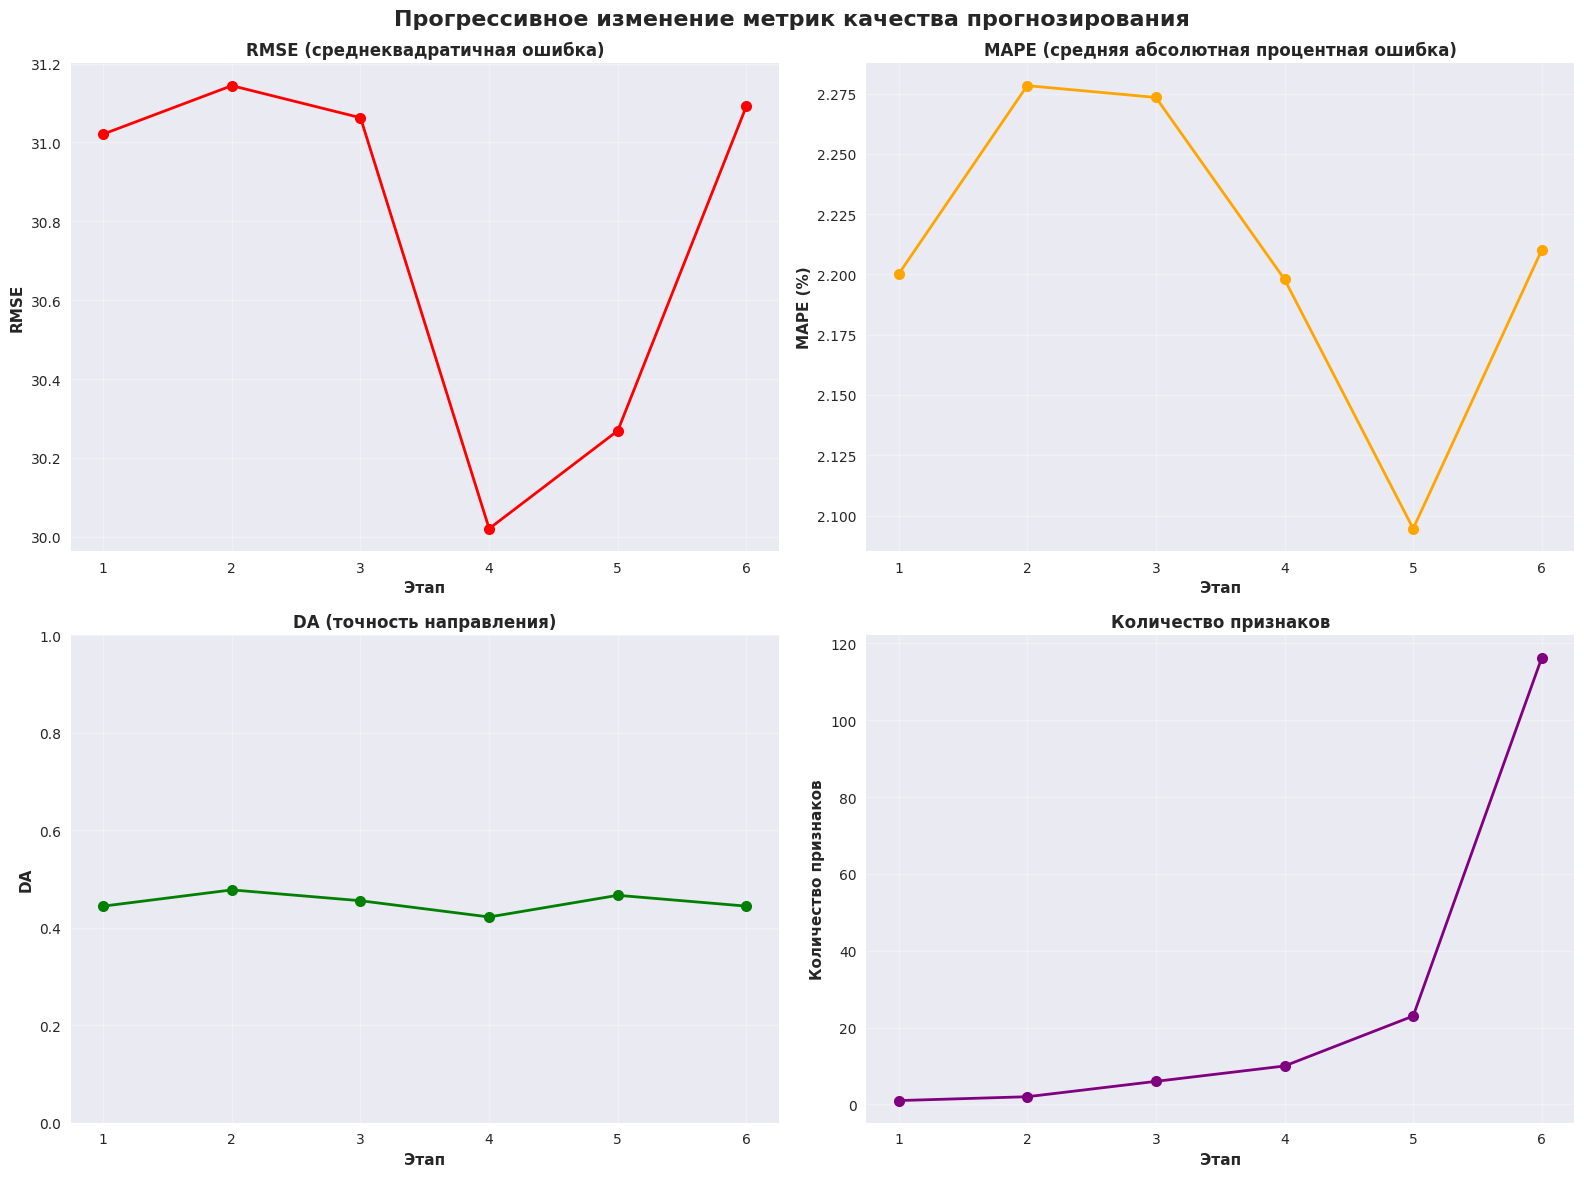

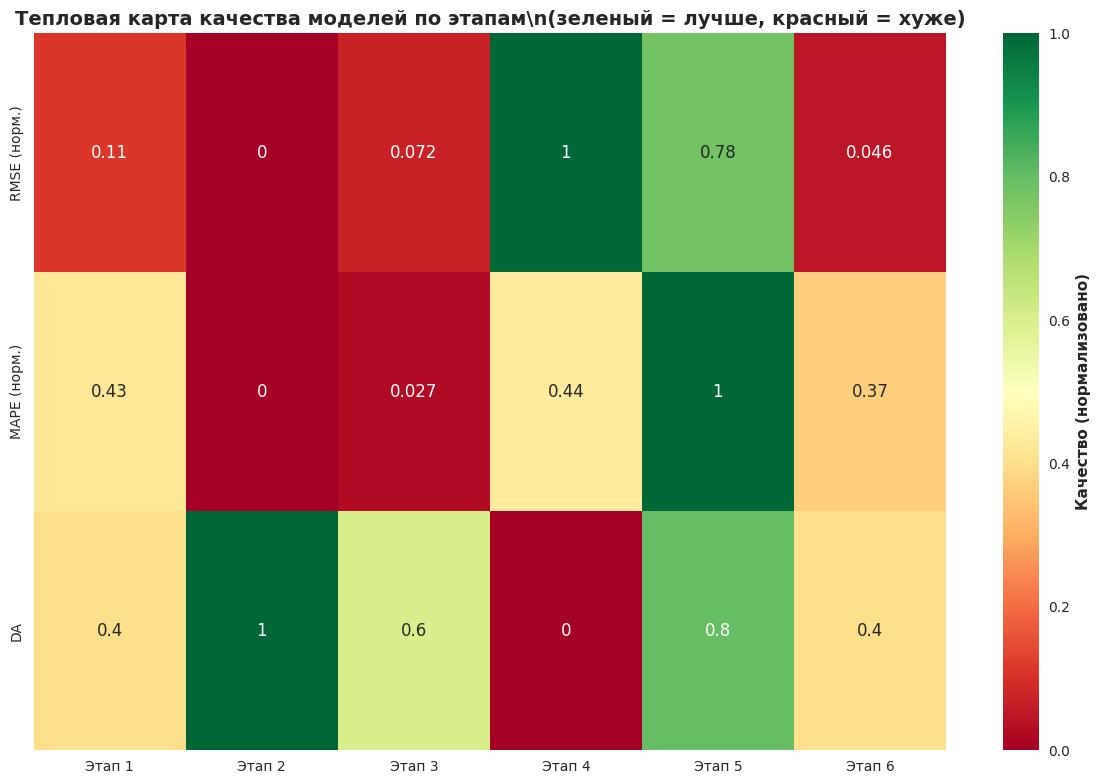

In [7]:
if not results_df.empty:
    # Создаем графики изменения метрик
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Прогрессивное изменение метрик качества прогнозирования', fontsize=16, fontweight='bold')
    
    # График 1: RMSE
    axes[0,0].plot(results_df['stage'], results_df['avg_rmse'], 'o-', linewidth=2, markersize=8, color='red')
    axes[0,0].set_title('RMSE (среднеквадратичная ошибка)', fontweight='bold')
    axes[0,0].set_xlabel('Этап')
    axes[0,0].set_ylabel('RMSE')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_xticks(results_df['stage'])
    
    # График 2: MAPE
    axes[0,1].plot(results_df['stage'], results_df['avg_mape'], 'o-', linewidth=2, markersize=8, color='orange')
    axes[0,1].set_title('MAPE (средняя абсолютная процентная ошибка)', fontweight='bold')
    axes[0,1].set_xlabel('Этап')
    axes[0,1].set_ylabel('MAPE (%)')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_xticks(results_df['stage'])
    
    # График 3: DA
    axes[1,0].plot(results_df['stage'], results_df['avg_da'], 'o-', linewidth=2, markersize=8, color='green')
    axes[1,0].set_title('DA (точность направления)', fontweight='bold')
    axes[1,0].set_xlabel('Этап')
    axes[1,0].set_ylabel('DA')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_xticks(results_df['stage'])
    axes[1,0].set_ylim(0, 1)
    
    # График 4: Количество признаков
    axes[1,1].plot(results_df['stage'], results_df['avg_features'], 'o-', linewidth=2, markersize=8, color='purple')
    axes[1,1].set_title('Количество признаков', fontweight='bold')
    axes[1,1].set_xlabel('Этап')
    axes[1,1].set_ylabel('Количество признаков')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].set_xticks(results_df['stage'])
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_PATH}metrics_progression.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Создаем heatmap сравнения метрик
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Подготавливаем данные для heatmap
    heatmap_data = results_df[['stage', 'avg_rmse', 'avg_mape', 'avg_da']].copy()
    
    # Нормализуем данные для лучшей визуализации (min-max scaling)
    for col in ['avg_rmse', 'avg_mape', 'avg_da']:
        min_val = heatmap_data[col].min()
        max_val = heatmap_data[col].max()
        if max_val > min_val:
            heatmap_data[col] = (heatmap_data[col] - min_val) / (max_val - min_val)
    
    # Для RMSE и MAPE - инвертируем (меньше = лучше)
    heatmap_data['avg_rmse'] = 1 - heatmap_data['avg_rmse']
    heatmap_data['avg_mape'] = 1 - heatmap_data['avg_mape']
    
    # Создаем heatmap
    heatmap_matrix = heatmap_data[['avg_rmse', 'avg_mape', 'avg_da']].T
    heatmap_matrix.columns = [f"Этап {i}" for i in results_df['stage']]
    heatmap_matrix.index = ['RMSE (норм.)', 'MAPE (норм.)', 'DA']
    
    sns.heatmap(heatmap_matrix, annot=True, cmap='RdYlGn', center=0.5, 
                cbar_kws={'label': 'Качество (нормализовано)'}, ax=ax)
    ax.set_title('Тепловая карта качества моделей по этапам\\n(зеленый = лучше, красный = хуже)', 
                 fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_PATH}quality_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("❌ Нет данных для визуализации")

## Анализ важности признаков


🎯 АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ПО ЭТАПАМ
\n📊 Этап 1: Базовая модель (close)
   (Важность признаков недоступна для univariate модели)
\n📊 Этап 2: + Аномалии
----------------------------------------
   Топ-10 важных признаков:
    1. close_lag_14: 0.8976
    2. close_lag_1: 0.0199
    3. close_lag_13: 0.0179
    4. close_lag_3: 0.0172
    5. close_lag_2: 0.0127
    6. close_lag_4: 0.0083
    7. close_lag_5: 0.0065
    8. close_lag_12: 0.0050
    9. close_lag_8: 0.0049
   10. close_lag_11: 0.0038
\n📊 Этап 3: + Новости
----------------------------------------
   Топ-10 важных признаков:
    1. close_lag_14: 0.9031
    2. close_lag_3: 0.0198
    3. close_lag_1: 0.0154
    4. close_lag_13: 0.0144
    5. close_lag_4: 0.0091
    6. close_lag_2: 0.0091
    7. close_lag_5: 0.0065
    8. close_lag_12: 0.0063
    9. close_lag_7: 0.0057
   10. close_lag_8: 0.0039
\n📊 Этап 4: + Свечи
----------------------------------------
   Топ-10 важных признаков:
    1. close_lag_14: 0.7225
    2. low_lag_7: 0.091

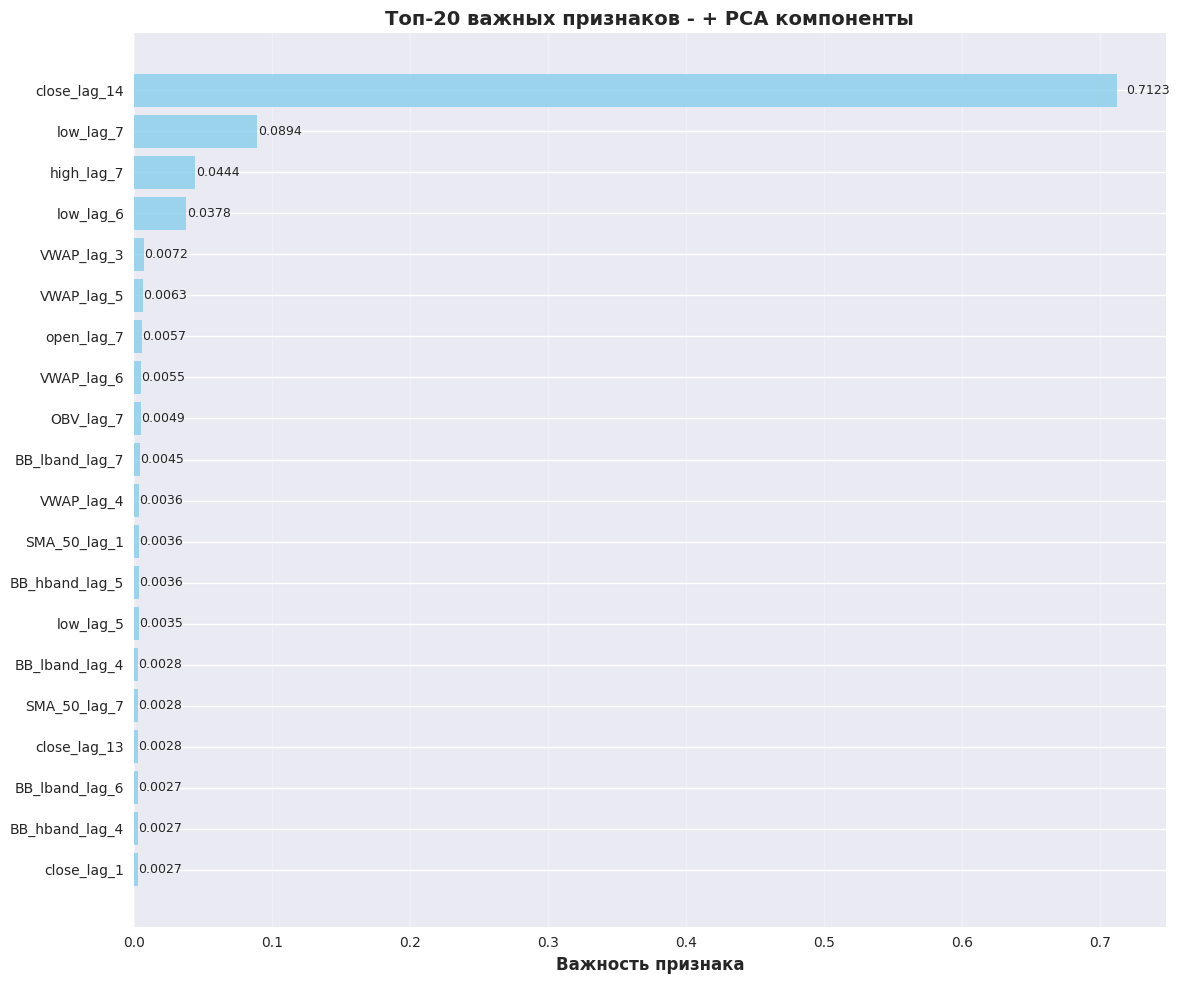

\n📋 СВОДНАЯ ТАБЛИЦА ВАЖНОСТИ ПРИЗНАКОВ
\nЭтап 2: + Аномалии
  1. close_lag_14: 0.8976
  2. close_lag_1: 0.0199
  3. close_lag_13: 0.0179
  4. close_lag_3: 0.0172
  5. close_lag_2: 0.0127
\nЭтап 3: + Новости
  1. close_lag_14: 0.9031
  2. close_lag_3: 0.0198
  3. close_lag_1: 0.0154
  4. close_lag_13: 0.0144
  5. close_lag_4: 0.0091
\nЭтап 4: + Свечи
  1. close_lag_14: 0.7225
  2. low_lag_7: 0.0916
  3. high_lag_7: 0.0486
  4. low_lag_6: 0.0417
  5. close_lag_3: 0.0144
\nЭтап 5: + Технические индикаторы
  1. close_lag_14: 0.7117
  2. low_lag_7: 0.0888
  3. high_lag_7: 0.0455
  4. low_lag_6: 0.0371
  5. VWAP_lag_7: 0.0081
\nЭтап 6: + PCA компоненты
  1. close_lag_14: 0.7123
  2. low_lag_7: 0.0894
  3. high_lag_7: 0.0444
  4. low_lag_6: 0.0378
  5. VWAP_lag_3: 0.0072
\n💾 Таблица важности признаков сохранена в ./progressive_analysis/feature_importance_summary.csv
\n✅ Анализ важности признаков завершен!


In [8]:
# Анализ важности признаков по этапам
print("🎯 АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ПО ЭТАПАМ")
print("=" * 60)

# Собираем важность признаков для каждого этапа
stage_importance = {}

for result in all_results:
    stage = result['stage']
    if stage not in stage_importance:
        stage_importance[stage] = {}
    
    # Агрегируем важность признаков по тикерам
    for feature, importance in result['feature_importance'].items():
        if feature not in stage_importance[stage]:
            stage_importance[stage][feature] = []
        stage_importance[stage][feature].append(importance)

# Вычисляем средние значения важности для каждого этапа
avg_importance = {}
for stage, features in stage_importance.items():
    avg_importance[stage] = {}
    for feature, values in features.items():
        avg_importance[stage][feature] = np.mean(values)

# Выводим топ-10 важных признаков для каждого этапа
for stage in sorted(avg_importance.keys()):
    if stage == 1:
        print(f"\\n📊 Этап {stage}: {stage_names[stage]}")
        print("   (Важность признаков недоступна для univariate модели)")
        continue
        
    print(f"\\n📊 Этап {stage}: {stage_names[stage]}")
    print("-" * 40)
    
    # Сортируем по важности
    sorted_features = sorted(avg_importance[stage].items(), key=lambda x: x[1], reverse=True)
    
    if sorted_features:
        print("   Топ-10 важных признаков:")
        for i, (feature, importance) in enumerate(sorted_features[:10], 1):
            print(f"   {i:2d}. {feature}: {importance:.4f}")
    else:
        print("   Нет данных о важности признаков")

# Создаем визуализацию важности признаков для последнего этапа
if avg_importance:
    last_stage = max(avg_importance.keys())
    if last_stage in avg_importance and avg_importance[last_stage]:
        
        print(f"\\n🎨 Создание визуализации важности признаков для этапа {last_stage}")
        
        # Берем топ-20 признаков для визуализации
        sorted_features = sorted(avg_importance[last_stage].items(), key=lambda x: x[1], reverse=True)
        top_features = sorted_features[:20]
        
        if top_features:
            features_names = [f[0] for f in top_features]
            features_importance = [f[1] for f in top_features]
            
            # Создаем горизонтальную диаграмму
            fig, ax = plt.subplots(1, 1, figsize=(12, 10))
            
            bars = ax.barh(range(len(features_names)), features_importance, color='skyblue', alpha=0.8)
            
            # Настраиваем оси
            ax.set_yticks(range(len(features_names)))
            ax.set_yticklabels(features_names, fontsize=10)
            ax.set_xlabel('Важность признака', fontsize=12)
            ax.set_title(f'Топ-20 важных признаков - {stage_names[last_stage]}', fontsize=14, fontweight='bold')
            
            # Добавляем значения на столбцы
            for i, bar in enumerate(bars):
                width = bar.get_width()
                ax.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                       f'{width:.4f}', ha='left', va='center', fontsize=9)
            
            # Инвертируем порядок для лучшего отображения
            ax.invert_yaxis()
            ax.grid(axis='x', alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(f"{OUTPUT_PATH}feature_importance_stage_{last_stage}.png", dpi=300, bbox_inches='tight')
            plt.show()

# Создаем сводную таблицу важности признаков
print("\\n📋 СВОДНАЯ ТАБЛИЦА ВАЖНОСТИ ПРИЗНАКОВ")
print("=" * 60)

# Создаем DataFrame для важности признаков
importance_data = []
for stage in sorted(avg_importance.keys()):
    if stage == 1:
        continue  # Пропускаем univariate модель
    
    sorted_features = sorted(avg_importance[stage].items(), key=lambda x: x[1], reverse=True)
    for rank, (feature, importance) in enumerate(sorted_features[:5], 1):  # Топ-5 для каждого этапа
        importance_data.append({
            'Этап': stage,
            'Описание этапа': stage_names[stage],
            'Ранг': rank,
            'Признак': feature,
            'Важность': importance
        })

if importance_data:
    importance_df = pd.DataFrame(importance_data)
    
    # Группируем по этапам и выводим
    for stage in sorted(importance_df['Этап'].unique()):
        stage_data = importance_df[importance_df['Этап'] == stage]
        print(f"\\nЭтап {stage}: {stage_data.iloc[0]['Описание этапа']}")
        for _, row in stage_data.iterrows():
            print(f"  {row['Ранг']}. {row['Признак']}: {row['Важность']:.4f}")
    
    # Сохраняем в файл
    importance_df.to_csv(f"{OUTPUT_PATH}feature_importance_summary.csv", index=False)
    print(f"\\n💾 Таблица важности признаков сохранена в {OUTPUT_PATH}feature_importance_summary.csv")

print("\\n✅ Анализ важности признаков завершен!")

## Выводы и рекомендации


In [9]:
print("🎯 РЕЗЮМЕ ПРОГРЕССИВНОГО АНАЛИЗА")
print("=" * 50)

if results_df.empty:
    print("❌ Нет результатов для анализа")
else:
    print(f"✅ Проанализировано {len(results_df)} этапов для {len(tickers)} тикеров")
    print(f"📊 Собрано {len(all_results)} успешных результатов")
    
    # Найдем лучший этап по каждой метрике
    best_rmse_stage = results_df.loc[results_df['avg_rmse'].idxmin()]
    best_mape_stage = results_df.loc[results_df['avg_mape'].idxmin()]
    best_da_stage = results_df.loc[results_df['avg_da'].idxmax()]
    
    print("\\n🏆 ЛУЧШИЕ РЕЗУЛЬТАТЫ:")
    print(f"   Лучший RMSE: Этап {best_rmse_stage['stage']} ({best_rmse_stage['stage_name']}) - {best_rmse_stage['avg_rmse']:.4f}")
    print(f"   Лучший MAPE: Этап {best_mape_stage['stage']} ({best_mape_stage['stage_name']}) - {best_mape_stage['avg_mape']:.2f}%")
    print(f"   Лучший DA: Этап {best_da_stage['stage']} ({best_da_stage['stage_name']}) - {best_da_stage['avg_da']:.3f}")
    
    # Анализ тренда качества
    base_metrics = results_df.iloc[0]
    final_metrics = results_df.iloc[-1]
    
    rmse_change = ((final_metrics['avg_rmse'] - base_metrics['avg_rmse']) / base_metrics['avg_rmse']) * 100
    mape_change = ((final_metrics['avg_mape'] - base_metrics['avg_mape']) / base_metrics['avg_mape']) * 100
    da_change = ((final_metrics['avg_da'] - base_metrics['avg_da']) / base_metrics['avg_da']) * 100
    
    print("\\n📈 ОБЩЕЕ УЛУЧШЕНИЕ (финальный этап vs базовая модель):")
    print(f"   RMSE: {rmse_change:+.1f}% ({'✅ улучшение' if rmse_change < 0 else '❌ ухудшение'})")
    print(f"   MAPE: {mape_change:+.1f}% ({'✅ улучшение' if mape_change < 0 else '❌ ухудшение'})")
    print(f"   DA: {da_change:+.1f}% ({'✅ улучшение' if da_change > 0 else '❌ ухудшение'})")
    
    # Рекомендации
    print("\\n💡 РЕКОМЕНДАЦИИ:")
    
    # Определяем наиболее эффективные этапы
    rmse_improvements = []
    mape_improvements = []
    da_improvements = []
    
    for i in range(1, len(results_df)):
        prev_metrics = results_df.iloc[i-1]
        curr_metrics = results_df.iloc[i]
        
        rmse_change = ((curr_metrics['avg_rmse'] - prev_metrics['avg_rmse']) / prev_metrics['avg_rmse']) * 100
        mape_change = ((curr_metrics['avg_mape'] - prev_metrics['avg_mape']) / prev_metrics['avg_mape']) * 100
        da_change = ((curr_metrics['avg_da'] - prev_metrics['avg_da']) / prev_metrics['avg_da']) * 100
        
        rmse_improvements.append((curr_metrics['stage'], rmse_change))
        mape_improvements.append((curr_metrics['stage'], mape_change))
        da_improvements.append((curr_metrics['stage'], da_change))
    
    # Находим этапы с наибольшими улучшениями
    best_rmse_improvement = min(rmse_improvements, key=lambda x: x[1])
    best_mape_improvement = min(mape_improvements, key=lambda x: x[1])
    best_da_improvement = max(da_improvements, key=lambda x: x[1])
    
    print(f"   1. Наибольшее улучшение RMSE дал этап {best_rmse_improvement[0]} ({best_rmse_improvement[1]:+.1f}%)")
    print(f"   2. Наибольшее улучшение MAPE дал этап {best_mape_improvement[0]} ({best_mape_improvement[1]:+.1f}%)")
    print(f"   3. Наибольшее улучшение DA дал этап {best_da_improvement[0]} ({best_da_improvement[1]:+.1f}%)")
    
    # Анализ эффективности по соотношению качества к сложности
    print("\\n⚖️ АНАЛИЗ ЭФФЕКТИВНОСТИ (качество vs сложность):")
    for _, row in results_df.iterrows():
        efficiency_score = (1 - row['avg_rmse']/base_metrics['avg_rmse']) / (row['avg_features']/base_metrics['avg_features'])
        print(f"   Этап {row['stage']}: Эффективность = {efficiency_score:.3f} (качество/сложность)")

print("\\n🎉 ПРОГРЕССИВНЫЙ АНАЛИЗ ЗАВЕРШЕН!")
print(f"📁 Все результаты сохранены в папке: {OUTPUT_PATH}")
print("\\nФайлы результатов:")
print("   - progressive_analysis_summary.csv - сводка по этапам")
print("   - progressive_analysis_formatted.csv - форматированная таблица")
print("   - feature_importance_summary.csv - важность признаков")
print("   - metrics_progression.png - графики изменения метрик")
print("   - quality_heatmap.png - тепловая карта качества")
print("   - feature_importance_stage_N.png - важность признаков для последнего этапа")

🎯 РЕЗЮМЕ ПРОГРЕССИВНОГО АНАЛИЗА
✅ Проанализировано 6 этапов для 10 тикеров
📊 Собрано 60 успешных результатов
\n🏆 ЛУЧШИЕ РЕЗУЛЬТАТЫ:
   Лучший RMSE: Этап 4 (+ Свечи) - 30.0208
   Лучший MAPE: Этап 5 (+ Технические индикаторы) - 2.09%
   Лучший DA: Этап 2 (+ Аномалии) - 0.478
\n📈 ОБЩЕЕ УЛУЧШЕНИЕ (финальный этап vs базовая модель):
   RMSE: +0.2% (❌ ухудшение)
   MAPE: +0.5% (❌ ухудшение)
   DA: +0.0% (❌ ухудшение)
\n💡 РЕКОМЕНДАЦИИ:
   1. Наибольшее улучшение RMSE дал этап 4 (-3.4%)
   2. Наибольшее улучшение MAPE дал этап 5 (-4.7%)
   3. Наибольшее улучшение DA дал этап 5 (+10.5%)
\n⚖️ АНАЛИЗ ЭФФЕКТИВНОСТИ (качество vs сложность):
   Этап 1: Эффективность = 0.000 (качество/сложность)
   Этап 2: Эффективность = -0.002 (качество/сложность)
   Этап 3: Эффективность = -0.000 (качество/сложность)
   Этап 4: Эффективность = 0.003 (качество/сложность)
   Этап 5: Эффективность = 0.001 (качество/сложность)
   Этап 6: Эффективность = -0.000 (качество/сложность)
\n🎉 ПРОГРЕССИВНЫЙ АНАЛИЗ ЗАВЕРШЕН!
📁